### Imports

In [1]:
import os
import joblib
import pandas as pd
import tqdm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils import resample

### Data loading

In [ ]:
path = 'train_data/'

In [ ]:
# Загружаем parquet файлы

def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

In [ ]:
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    preprocessed_frames = []

    columns = ['id',
               'rn',
               'pre_since_opened',
               'pre_since_confirmed',
               'pre_pterm',
               'pre_fterm',
               'pre_till_pclose',
               'pre_till_fclose',
               'pre_loans_credit_limit',
               'pre_loans_next_pay_summ',
               'pre_loans_outstanding',
               'pre_loans_total_overdue',
               'pre_loans_max_overdue_sum',
               'pre_loans_credit_cost_rate',
               'pre_loans5',
               'pre_loans530',
               'pre_loans3060',
               'pre_loans6090',
               'pre_loans90',
               'is_zero_loans5',
               'is_zero_loans530',
               'is_zero_loans3060',
               'is_zero_loans6090',
               'is_zero_loans90',
               'pre_util',
               'pre_over2limit',
               'pre_maxover2limit',
               'is_zero_util',
               'is_zero_over2limit',
               'is_zero_maxover2limit',
               'enc_paym_0',
               'enc_paym_1',
               'enc_paym_2',
               'enc_paym_3',
               'enc_paym_4',
               'enc_paym_5',
               'enc_paym_6',
               'enc_paym_7',
               'enc_paym_8',
               'enc_paym_9',
               'enc_paym_10',
               'enc_paym_11',
               'enc_paym_12',
               'enc_paym_13',
               'enc_paym_14',
               'enc_paym_15',
               'enc_paym_16',
               'enc_paym_17',
               'enc_paym_18',
               'enc_paym_19',
               'enc_paym_20',
               'enc_paym_21',
               'enc_paym_22',
               'enc_paym_23',
               'enc_paym_24',
               'enc_loans_account_holder_type',
               'enc_loans_credit_status',
               'enc_loans_credit_type',
               'enc_loans_account_cur',
               'pclose_flag',
               'fclose_flag']

    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,columns=columns,
                                                             verbose=verbose)


        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame)
    return pd.concat(preprocessed_frames)

In [ ]:
data = prepare_transactions_dataset(path, num_parts_to_preprocess_at_once=2, num_parts_total=12,
                                    save_to_path='train_data/')

C:\Users\mayor\AppData\Local\Temp\ipykernel_14184\3596758758.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),


Transforming transactions data:   0%|          | 0/6 [00:00<?, ?it/s]

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


C:\Users\mayor\AppData\Local\Temp\ipykernel_14184\3570205359.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_0.pq
chunk_path train_data/train_data_1.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


C:\Users\mayor\AppData\Local\Temp\ipykernel_14184\3570205359.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_10.pq
chunk_path train_data/train_data_11.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


C:\Users\mayor\AppData\Local\Temp\ipykernel_14184\3570205359.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_2.pq
chunk_path train_data/train_data_3.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


C:\Users\mayor\AppData\Local\Temp\ipykernel_14184\3570205359.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_4.pq
chunk_path train_data/train_data_5.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


C:\Users\mayor\AppData\Local\Temp\ipykernel_14184\3570205359.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_6.pq
chunk_path train_data/train_data_7.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


C:\Users\mayor\AppData\Local\Temp\ipykernel_14184\3570205359.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_8.pq
chunk_path train_data/train_data_9.pq


In [ ]:
data.head()

,id,enc_paym_0,enc_paym_1,enc_paym_2,enc_paym_3,enc_paym_4,enc_paym_5,enc_paym_6,enc_paym_7,enc_paym_8,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,0,0,3,3,3,3,3,3,3,...,3,3,3,4,1,3,4,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,1,3,4,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,1,2,3,1,1,1
3,0,1,0,0,0,0,0,0,0,0,...,3,3,3,4,1,3,1,1,0,0
4,0,0,0,0,0,0,0,0,3,3,...,3,3,3,4,1,3,4,1,0,0


In [ ]:
# Объединяем данные по id, выбираем моду в качестве значения
data = data.groupby(['id'], as_index=False).agg(lambda x: pd.Series.mode(x)[0])

In [ ]:
data.to_csv('data.csv')

### Data preparation

In [2]:

data = pd.read_csv('data/data.csv', index_col=0, dtype=int)

In [3]:
data.shape

(3000000, 61)

In [4]:
# Создаем новые признаки на основе исходных

data['is_zero_loans'] = np.where((data['is_zero_loans5'] == 1) & (data['is_zero_loans530'] == 1) & (data['is_zero_loans3060'] == 1)
& (data['is_zero_loans6090'] == 1) & (data['is_zero_loans90'] == 1), 1, 0)

data['is_zero_overlimit'] = np.where((data['is_zero_over2limit'] == 1) & (data['is_zero_maxover2limit'] == 1), 1, 0)

In [5]:
# Загружаем файл с целевым признаком

train_target = pd.read_csv('data/train_target.csv', dtype=int)

In [6]:

train_target.head()

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [7]:
# Объединяем датасеты

data = pd.merge(left=data,right=train_target, how='inner', on='id')

In [8]:
data.head()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,is_zero_loans,is_zero_overlimit,flag
0,0,1,18,9,2,2,12,8,11,2,...,4,1,3,4,1,0,0,1,1,0
1,1,1,14,7,1,6,9,1,6,2,...,4,1,3,4,1,0,0,1,1,0
2,2,1,0,9,4,8,1,11,1,1,...,4,1,2,3,1,1,1,1,1,0
3,3,1,1,9,4,8,1,11,11,2,...,4,1,3,4,1,0,0,1,1,0
4,4,1,12,9,4,8,1,11,12,1,...,4,1,2,3,1,1,1,1,1,0


In [9]:
data.shape

(3000000, 64)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000000 entries, 0 to 2999999
Data columns (total 64 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int32
 1   rn                             int32
 2   pre_since_opened               int32
 3   pre_since_confirmed            int32
 4   pre_pterm                      int32
 5   pre_fterm                      int32
 6   pre_till_pclose                int32
 7   pre_till_fclose                int32
 8   pre_loans_credit_limit         int32
 9   pre_loans_next_pay_summ        int32
 10  pre_loans_outstanding          int32
 11  pre_loans_total_overdue        int32
 12  pre_loans_max_overdue_sum      int32
 13  pre_loans_credit_cost_rate     int32
 14  pre_loans5                     int32
 15  pre_loans530                   int32
 16  pre_loans3060                  int32
 17  pre_loans6090                  int32
 18  pre_loans90                    int32
 19  

In [11]:
data.describe()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,is_zero_loans,is_zero_overlimit,flag
count,3.000000e+06,3000000.0,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,...,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06
mean,1.500000e+06,1.0,7.272695e+00,6.923409e+00,6.139337e+00,6.855558e+00,4.070016e+00,8.208710e+00,7.415366e+00,2.044004e+00,...,3.813093e+00,1.007954e+00,2.651121e+00,3.537072e+00,1.000097e+00,5.444733e-02,1.182127e-01,8.744663e-01,9.363847e-01,3.548067e-02
std,8.660255e+05,0.0,5.701003e+00,4.174678e+00,4.918956e+00,3.814930e+00,4.550534e+00,3.997183e+00,5.844909e+00,8.676214e-01,...,7.223905e-01,1.433960e-01,4.823449e-01,8.625528e-01,1.809210e-02,2.268983e-01,3.228598e-01,3.313231e-01,2.440665e-01,1.849914e-01
min,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.499998e+05,1.0,2.000000e+00,4.000000e+00,3.000000e+00,5.000000e+00,1.000000e+00,5.000000e+00,2.000000e+00,2.000000e+00,...,4.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,1.500000e+06,1.0,6.000000e+00,7.000000e+00,4.000000e+00,8.000000e+00,1.000000e+00,1.100000e+01,6.000000e+00,2.000000e+00,...,4.000000e+00,1.000000e+00,3.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
75%,2.249999e+06,1.0,1.200000e+01,9.000000e+00,9.000000e+00,8.000000e+00,7.000000e+00,1.100000e+01,1.300000e+01,2.000000e+00,...,4.000000e+00,1.000000e+00,3.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
max,2.999999e+06,1.0,1.900000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.500000e+01,1.900000e+01,6.000000e+00,...,4.000000e+00,6.000000e+00,6.000000e+00,7.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [12]:
data.drop(columns='id').duplicated().sum()

171161

In [13]:
# Удаляем дубликаты в данных где совпадают все строки кроме признака id

data = data.drop_duplicates(subset=data.columns.difference(['id']))

In [14]:
data.isna().sum()

id                     0
rn                     0
pre_since_opened       0
pre_since_confirmed    0
pre_pterm              0
                      ..
pclose_flag            0
fclose_flag            0
is_zero_loans          0
is_zero_overlimit      0
flag                   0
Length: 64, dtype: int64

In [15]:
data['flag'].value_counts()

0    2724314
1     104525
Name: flag, dtype: int64

In [16]:
# Разделяем выборку с соблюдением баланса целевого признака

df_train, df_test = train_test_split(data, stratify=data['flag'], test_size=0.3, random_state=42)

In [17]:
df_min = df_train[df_train['flag'] == 1]
df_maj = df_train[df_train['flag'] == 0]

In [18]:
# Применяем метод downsampling к данным, чтобы сбалансировать классы

df_maj_downsample = resample(df_maj, replace=False, n_samples=len(df_min), random_state=42)

print(df_maj_downsample.shape)
print(df_min.shape)

(73167, 64)
(73167, 64)


In [19]:
df_train= pd.concat([df_maj_downsample, df_min], ignore_index=True).sample(frac=1.)

### Feature selection

In [20]:
x_train = df_train.drop(columns=['flag', 'id', 'rn'])
y_train = df_train.flag

x_test = df_test.drop(columns=['flag', 'id', 'rn'])
y_test = df_test.flag

In [27]:
# Строим пайплайн для, того чтобы понять оптимальное число признаков и лучшую функцию оценки для модели случайного леса

rf = Pipeline([
    ('selector', GenericUnivariateSelect(mode='k_best')),
    ('rf', RandomForestClassifier())
     ])

params = {'selector__param': np.arange(10,62),
          'selector__score_func': (mutual_info_classif, chi2)}
gs = GridSearchCV(rf, params, cv=5, scoring='roc_auc', n_jobs=-1)
gs.fit(x_train, y_train)

print(f'Best score: {gs.best_score_}')
print(f'Best parameters: {gs.best_params_}')

Best score: 0.6598348157087521
Best parameters: {'selector__param': 59, 'selector__score_func': <function chi2 at 0x000001C98865ACA0>}


In [21]:
selector = GenericUnivariateSelect(mode='k_best', score_func=chi2, param=59)
x_train_se = selector.fit_transform(x_train, y_train)
x_test_se = selector.transform(x_test)


In [22]:
scale = StandardScaler()
x_train_sc = scale.fit_transform(x_train)
x_test_sc = scale.transform(x_test)

### Modeling

In [23]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rfc = RandomForestClassifier()
lr = LogisticRegression()
gbc = GradientBoostingClassifier()

In [31]:
# Строим модели с параметрами по умолчанию и проверям их с помощью кросс-валидации

scores = cross_val_score(rfc, x_train_se, y_train, cv=kf, scoring='roc_auc', n_jobs=-1)
print('scores = {} \nmean score = {:.4f} +/- {:.4f}'.format(scores, scores.mean(), scores.std()))

scores = [0.65679732 0.65879427 0.65769308 0.6643552  0.65807549] 
mean score = 0.6591 +/- 0.0027


In [27]:
scores = cross_val_score(gbc, x_train_se, y_train, cv=kf, scoring='roc_auc', n_jobs=-1)
print('scores = {} \nmean score = {:.4f} +/- {:.4f}'.format(scores, scores.mean(), scores.std()))

scores = [0.6734118  0.68069472 0.68373319 0.67644947 0.67207972] 
mean score = 0.6773 +/- 0.0044


In [32]:
scores = cross_val_score(lr, x_train_sc, y_train, cv=kf, scoring='roc_auc', n_jobs=-1)
print('scores = {} \nmean score = {:.4f} +/- {:.4f}'.format(scores, scores.mean(), scores.std()))

scores = [0.65294286 0.66088641 0.65704553 0.65927759 0.65893818] 
mean score = 0.6578 +/- 0.0027


In [46]:
# Осуществляем подбор гиперпараметров моделей

params = {'n_estimators' : [300, 500, 700],
          'max_depth': np.arange(10, 60, 4),
          'min_samples_leaf': np.arange(1, 10, 1),
          'min_samples_split': np.arange(2, 20, 2)}

rs = RandomizedSearchCV(rfc, params, cv=kf, scoring='roc_auc', n_jobs=-1, error_score='raise')
rs.fit(x_train_se, y_train)

print('Best params: ', rs.best_params_)
print('Best score: ', rs.best_score_)

Best params:  {'n_estimators': 300, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_depth': 50}
Best score:  0.6797882562529096


In [28]:
params = {"loss":["log_loss", "exponential"],
          "learning_rate": [0.01,0.1,1,10,100],
          'max_depth': np.arange(2, 60, 4),
          'max_features': ['sqrt', 'log2', None],
          'min_samples_leaf': np.arange(1, 10, 1),
          'min_samples_split': np.arange(2, 20, 2),
          "max_features":["log2","sqrt"],
          "criterion": ["friedman_mse",  "squared_error"],
          "subsample":np.arange(0.1, 1, 0.1),
          "n_estimators":[100, 300, 500]}

gs = RandomizedSearchCV(gbc, params, cv=kf, scoring='roc_auc', n_jobs=-1)
gs.fit(x_train_se, y_train)

print('Лучшие параметры: ', gs.best_params_)
print('Лучший результат: ', gs.best_score_)

Лучшие параметры:  {'subsample': 0.30000000000000004, 'n_estimators': 100, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 'log2', 'max_depth': 58, 'loss': 'log_loss', 'learning_rate': 0.01, 'criterion': 'squared_error'}
Лучший результат:  0.6775320592391195


In [47]:
# Обучаем модель с лучшими результатами

rfc = RandomForestClassifier(n_estimators=300, max_depth=50, max_features='sqrt', min_samples_split=16, min_samples_leaf=3)
rfc.fit(x_train_se, y_train)

RandomForestClassifier(max_depth=50, min_samples_leaf=3, min_samples_split=16,
                       n_estimators=300)

In [48]:
rfc_pred = rfc.predict_proba(x_test_se)[:,1]
rfc_auc = roc_auc_score(y_test, rfc_pred)
print(f'Random forrest roc-auc score is: {rfc_auc}')

Random forrest roc-auc score is: 0.6794099484265277


Text(0, 0.5, 'tpr')

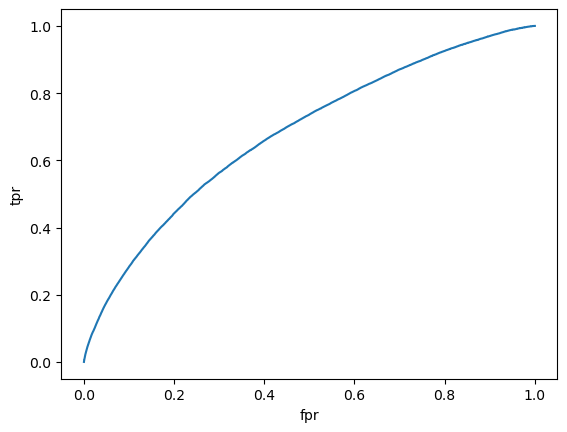

In [49]:
# Визуализируем кривую roc-auc

fpr, tpr, _ = roc_curve(y_test, rfc_pred)
plt.plot(fpr, tpr, '-')
plt.xlabel('fpr')
plt.ylabel('tpr')

In [ ]:
df_submission = pd.DataFrame(data= {
    'id': df_test['id'],
    'flag': rfc_pred
})
df_submission.head()

In [ ]:
df_submission.to_csv('submission.csv', index=False)

### Pipeline

In [ ]:
# Создаем пайплайн для обучения модели на всей выборке с предварительным отбором признаков и сохраням полученную модель в pickle файл

df_min = data[data['flag'] == 1]
df_maj = data[data['flag'] == 0]

df_maj_downsample = resample(df_maj, replace=False, n_samples=len(df_min), random_state=42)

print(df_maj_downsample.shape)
print(df_min.shape)

df = pd.concat([df_maj_downsample, df_min], ignore_index=True).sample(frac=1.)

x = df.drop(columns=['flag', 'id', 'rn'])
y = df.flag

rfc = RandomForestClassifier(n_estimators=500, max_depth=26, max_features='sqrt', min_samples_split=16, min_samples_leaf=2)
selector = GenericUnivariateSelect(mode='k_best', score_func=chi2, param=56)
pipe = Pipeline([('selector', selector), ('classifier', rfc)])
pipe.fit(x, y)

joblib.dump(pipe, 'scoring_pipe.pkl')